# Regressão linear múltipla

In [55]:
import pandas as pd
import numpy as np

In [56]:
enem = pd.read_csv('dados/enem_2019_tratado.csv', sep=',', encoding='iso-8859-1')

In [57]:
enem.shape

(499940, 28)

##### Objetivo: Criar um modelo matemático de regressão linear múltipla para prever a nota de redação tendo como variáveis independentes as notas de seus componentes.

Selecionando um colégio

In [58]:
colegiox = enem.loc[enem.CO_ESCOLA == 35132287]

## Regressão múltipla com statsmodels

Modelo 1

In [59]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [60]:
# Nota redação é variável dependente
modelo1 = smf.ols('NOTA_REDACAO ~ COMP2 + COMP4 + COMP5', data = colegiox).fit()

In [61]:
residuos = modelo1.resid
residuos

17        -4.498054
10760     33.309358
13315     -5.718021
20006    -26.432059
26697      1.349594
            ...    
426829    35.760528
428241   -17.683137
443242   -17.497499
462446   -56.783460
483420    34.529325
Length: 130, dtype: float64

## Teste de normalidade dos resíduos

In [62]:
import scipy.stats as stats

H0 - distribuição normal: p > 0.05 <br>
Ha - distribuição != normal: P <= 0.05

In [63]:
estatistica, p = stats.shapiro(residuos)
print(f'Estatística do teste: {estatistica}')
print(f'             P-valor: {p}')

Estatística do teste: 0.9847341775894165
             P-valor: 0.15436169505119324


In [64]:
import matplotlib.pyplot as plt

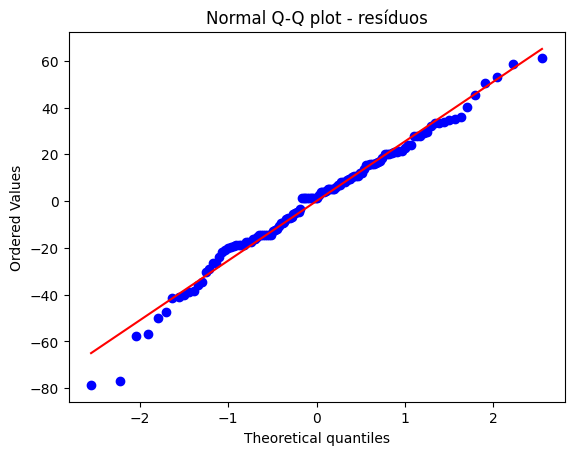

In [65]:
stats.probplot(residuos, dist='norm', plot=plt)
plt.title('Normal Q-Q plot - resíduos')
plt.show()

### Análise da homocedasticidade dos resíduos

(resíduos com variação constante)

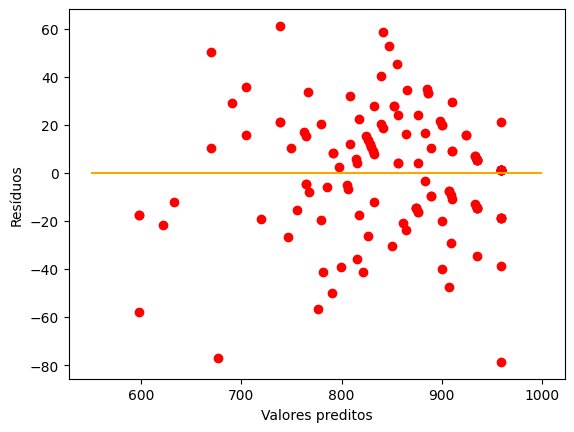

In [66]:
plt.scatter(y=residuos, x=modelo1.predict(), color='red')
plt.hlines(y=0, xmin=550, xmax=1000, color='orange')
plt.ylabel('Resíduos')
plt.xlabel('Valores preditos')
plt.show()
# Nota máxima da redação é 1000

### Teste Breusch-Pagan (Homocedasticidade ou heterocedasticidade)

H0 - Existe homocedasticidade: p > 0.05 <br>
Ha - Não existe homocedasticidade: P <= 0.05

In [67]:
from statsmodels.compat import lzip

In [68]:
estatistica, p, f, fp = sms.het_breuschpagan(modelo1.resid, modelo1.model.exog)
print(f'Estatística de teste: {estatistica}')
print(f'             P-valor: {p}')
print(f'             F-valor: {f}')
print(f'         F_p- valor:  {fp}')

Estatística de teste: 7.939832568694114
             P-valor: 0.047271689874476004
             F-valor: 2.732037608197022
         F_p- valor:  0.04659801474386854


## Outliers nos resíduos
(Entre -3 e 3)

In [69]:
outliers = modelo1.outlier_test()

In [70]:
outliers.max()

student_resid    2.466219
unadj_p          0.957876
bonf(p)          1.000000
dtype: float64

In [71]:
outliers.min()

student_resid   -3.260297
unadj_p          0.001434
bonf(p)          0.186452
dtype: float64

## Independência dos resíduos (Durbin-Watson)
ideal para medidas repetidas (longitudinais, ex: mesmo aluno)

A estatística de teste é aproximadamente igual a 2 * (1-r) onde r é a autocorrelação da amostra de resíduos. Assim, para r = 0, a estatística de teste é igual a 2, indicando independência dos resíduos (o resultado vai de 0 a 4)

In [72]:
import statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning

In [73]:
estatistica = statsmodels.stats.stattools.durbin_watson(modelo1.resid)
print(f'estatística do teste: {estatistica}')

estatística do teste: 2.0810835654651636


## Ausência de multicolinearidade

Somente entre as variáveis independentes. <br>
Considerada multicolinearidade quando r > 0.9

In [74]:
variaveis = colegiox[['COMP2', 'COMP4', 'COMP5']]

In [75]:
correlacoes = variaveis.corr(method='pearson')
correlacoes
# Ausência de multicolinearidade

,COMP2,COMP4,COMP5
COMP2,1.000000,0.375906,0.298434
COMP4,0.375906,1.000000,0.428872
COMP5,0.298434,0.428872,1.000000


Usando fator de inflação de variância (VIF)

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [77]:
# Função espera a presença de uma constante na matriz de variáveis explicativas
vif = add_constant(variaveis)
pd.Series([variance_inflation_factor(vif.values, j) for j in range(vif.shape[1])], index=vif.columns)

const    72.466982
COMP2     1.196714
COMP4     1.335832
COMP5     1.259221
dtype: float64

## Análise do modelo

Análise do modelo <br>
Intercept <br>
p_valor para cada coeficiente < 0.05 (estatisticamente significativos)<br>
Adjusted R-squared (explicação domodelo através  dos dados).<br>
p_valor da estatística F < 0.05 (valida o modelo de regressão)

In [78]:
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:           NOTA_REDACAO   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     507.2
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           3.97e-70
Time:                        12:18:58   Log-Likelihood:                -604.30
No. Observations:                 130   AIC:                             1217.
Df Residuals:                     126   BIC:                             1228.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    116.1987     19.162      6.064      0.0

Os coeficientes [COMP2, COMP4, COMP5] na variável P>|t| estão significativos

<b>Equação:</b> Nota Redação = 116.1987 + 1.2831.COMP2 + 1.7298.COMP4 + 1.1993.COMP5 

In [79]:
# Criando uma coluna com previsão
colegiox['previsao'] = modelo1.fittedvalues

/tmp/ipykernel_8332/1778108495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colegiox['previsao'] = modelo1.fittedvalues


In [80]:
colegiox.head(10)

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,IDADE,SEXO,TP_ESTADO_CIVIL,RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,ESCOLA,CO_ESCOLA,...,TP_LINGUA,TP_STATUS_REDACAO,COMP1,COMP2,COMP3,COMP4,COMP5,NOTA_REDACAO,INTERNET,previsao
17,"1,90E+11",São Paulo,18,F,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,160.0,140.0,140.0,160.0,160.0,760.0,Sim,764.498054
10760,"1,90E+11",São Paulo,17,M,1,parda,1,2,privada,35132287.0,...,Inglês,1.0,180.0,200.0,200.0,200.0,140.0,920.0,Sim,886.690642
13315,"1,90E+11",São Paulo,17,F,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,160.0,140.0,160.0,200.0,120.0,780.0,Sim,785.718021
20006,"1,90E+11",São Paulo,17,F,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,140.0,180.0,160.0,180.0,140.0,800.0,Sim,826.432059
26697,"1,90E+11",São Paulo,18,F,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,160.0,200.0,200.0,200.0,200.0,960.0,Sim,958.650406
26911,"1,90E+11",São Paulo,18,F,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,160.0,120.0,160.0,160.0,180.0,780.0,Sim,762.822631
43814,"1,90E+11",São Paulo,18,M,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,160.0,160.0,160.0,140.0,180.0,800.0,Sim,779.550082
43870,"1,90E+11",São Paulo,17,F,1,preta,2,2,privada,35132287.0,...,Inglês,1.0,140.0,200.0,160.0,180.0,180.0,860.0,Sim,900.067246
44150,"1,90E+11",São Paulo,17,F,1,amarela,1,2,privada,35132287.0,...,Inglês,1.0,160.0,200.0,200.0,200.0,200.0,960.0,Sim,958.650406
48417,"1,90E+11",São Paulo,17,M,1,branca,1,2,privada,35132287.0,...,Inglês,1.0,140.0,120.0,140.0,120.0,160.0,680.0,Sim,669.642901


## Modelo 2

In [81]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [82]:
# Criação do modelo, verificar se fica melhor com apenas duas variáveis independentes
modelo2 = smf.ols('NOTA_REDACAO ~ COMP2 + COMP4', data=colegiox).fit()

In [83]:
residuos2 = modelo2. resid
residuos2

17         -5.800864
10760     -19.726164
13315     -73.382235
20006     -67.154169
26697      20.273836
             ...    
426829     46.771131
428241    -69.438183
443242    -52.144793
462446   -118.372859
483420     47.855207
Length: 130, dtype: float64

## Teste de Normalidade dos resíduos

In [84]:
import scipy.stats as stats

Ho = distribuição normal: p > 0.05 <br>
Ha = distribuição != normal: p <= 0.05

In [85]:
estatistica, p_valor = stats.shapiro(residuos2)
print(f'Estatística do teste: {estatistica}')
print(f'             P-valor: {p_valor}')
# Distribuição normal

Estatística do teste: 0.9847795367240906
             P-valor: 0.15595780313014984


In [86]:
import matplotlib.pyplot as plt

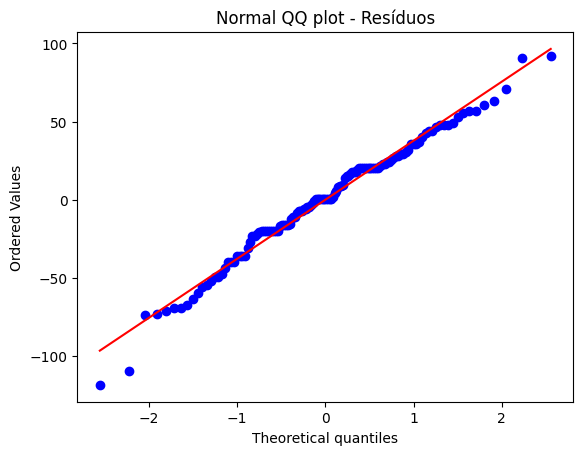

In [87]:
stats.probplot(residuos2, dist='norm', plot=plt)
plt.title('Normal QQ plot - Resíduos')
plt.show()

## Análise da homocedasticidade dos resíduos

(resíduos com variação constante)

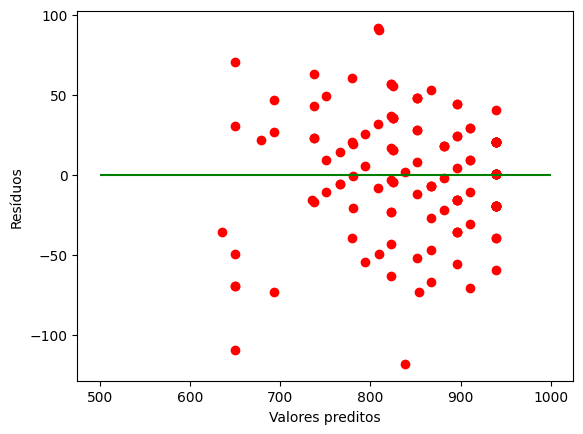

In [88]:
plt.scatter(y=residuos2, x=modelo2.predict(), color='red')
plt.hlines(y=0, xmin=500, xmax=1000, color='green')
plt.ylabel('Resíduos')
plt.xlabel('Valores preditos')
plt.show()

## Teste Breusch-Pagan (Homocedasticidade ou heterocedasticidade)

Ho = Existe homocedasticidade: p > 0.05 <br>
Ha = Não existe homocedasticidade: p <= 0.05

In [89]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [90]:
estatistica, p_valor, f, fp = sms.het_breuschpagan (modelo2.resid, modelo2.model.exog)
print(f"Estatística do teste: {estatistica}")
print(f"             P-valor: {p_valor}")
print(f"             F-valor: {f}")
print(f"           f_p-valor: {fp}")

# Não existe homocedasticidade

Estatística do teste: 15.042745745701497
             P-valor: 0.0005413887974310043
             F-valor: 8.309300366021285
           f_p-valor: 0.00040612282224010204


## Outliers nos resíduos
(Entre -3 e 3)

In [91]:
outliers = modelo2.outlier_test()

In [92]:
outliers.max()

student_resid    2.521846
unadj_p          0.994221
bonf(p)          1.000000
dtype: float64

In [93]:
outliers.min()

student_resid   -3.254277
unadj_p          0.001460
bonf(p)          0.189769
dtype: float64

## Independência dos resíduos (Durbin-Watson)

Ideal para medidas repetidas (longitudinais, ex: mesmo aluno)
- não adequado para este teste

In [94]:
import statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning

In [95]:
estatistica = statsmodels.stats.stattools.durbin_watson(modelo2.resid)
print(f'Estatística de teste: {estatistica}')

Estatística de teste: 1.7307261063145127


## Ausência de multicolinearidade

Somente entre as variáveis independentes. <br>
Considerada multicolinearidade quando r > 0.9

In [96]:
var2 = colegiox[['COMP2', 'COMP4']]

In [97]:
var2.head()

,COMP2,COMP4
17,140.0,160.0
10760,200.0,200.0
13315,140.0,200.0
20006,180.0,180.0
26697,200.0,200.0


In [98]:
correlacoes = var2.corr(method='pearson')
correlacoes

,COMP2,COMP4
COMP2,1.000000,0.375906
COMP4,0.375906,1.000000


### Usando Fator de inflação de variância (VIF)

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [100]:
vif = add_constant(var2) # Essa função espera a presença de uma constante na matriz de variáveis explicativas
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)
# Está aprovado quanto a multicolinearidade

const    59.966319
COMP2     1.164559
COMP4     1.164559
dtype: float64

## Análise do modelo

Intercept <br>
p_valor para cada coeficiente <0.05 (estatisticamente significativos).<br>
Adjusted R-squared (explicação do modelo através dos dados). <br>
p_valor da estatística F < 0.05 (valida o modelo de regressão).

In [101]:
print(modelo2.summary())

                            OLS Regression Results                            
Dep. Variable:           NOTA_REDACAO   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     314.2
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           6.76e-50
Time:                        12:18:58   Log-Likelihood:                -655.51
No. Observations:                 130   AIC:                             1317.
Df Residuals:                     127   BIC:                             1326.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    214.0062     25.745      8.313      0.0

In [102]:
print(modelo2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.829    
Dependent Variable: NOTA_REDACAO     AIC:                1317.0150
Date:               2023-02-06 12:18 BIC:                1325.6176
No. Observations:   130              Log-Likelihood:     -655.51  
Df Model:           2                F-statistic:        314.2    
Df Residuals:       127              Prob (F-statistic): 6.76e-50 
R-squared:          0.832            Scale:              1436.8   
-------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept   214.0062   25.7446   8.3127  0.0000  163.0623  264.9501
COMP2         1.4391    0.1128  12.7577  0.0000    1.2159    1.6623
COMP4         2.1895    0.1441  15.1988  0.0000    1.9045    2.4746
------------------------------------------------------------------
Omnibus

<b>Fórmula/ Equação: </b> Nota redação = 214.0062 + 1.4391.COMP2 + 2.1895.COMP4

In [103]:
# Criando uma coluna com previsão
colegiox['previsao2'] = modelo2.fittedvalues

/tmp/ipykernel_8332/3604984769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colegiox['previsao2'] = modelo2.fittedvalues


In [104]:
colegiox.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,IDADE,SEXO,TP_ESTADO_CIVIL,RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,ESCOLA,CO_ESCOLA,...,TP_STATUS_REDACAO,COMP1,COMP2,COMP3,COMP4,COMP5,NOTA_REDACAO,INTERNET,previsao,previsao2
17,"1,90E+11",São Paulo,18,F,1,branca,1,2,privada,35132287.0,...,1.0,160.0,140.0,140.0,160.0,160.0,760.0,Sim,764.498054,765.800864
10760,"1,90E+11",São Paulo,17,M,1,parda,1,2,privada,35132287.0,...,1.0,180.0,200.0,200.0,200.0,140.0,920.0,Sim,886.690642,939.726164
13315,"1,90E+11",São Paulo,17,F,1,branca,1,2,privada,35132287.0,...,1.0,160.0,140.0,160.0,200.0,120.0,780.0,Sim,785.718021,853.382235
20006,"1,90E+11",São Paulo,17,F,1,branca,1,2,privada,35132287.0,...,1.0,140.0,180.0,160.0,180.0,140.0,800.0,Sim,826.432059,867.154169
26697,"1,90E+11",São Paulo,18,F,1,branca,1,2,privada,35132287.0,...,1.0,160.0,200.0,200.0,200.0,200.0,960.0,Sim,958.650406,939.726164


## Comparação entre modelos

#### Critério de informação de Akaike (AIC) 

O melhor modelo é com o resultado menor(menor variaçãodos resíduos)

In [105]:
modelo1.aic

1216.59304638052

In [106]:
modelo2.aic

1317.0150160308585

## Critédio de  informação Bayesiano (BIC)

O melhor modelo é com o resultador menor (menor variação dos resíduos)

In [107]:
modelo1.bic

1228.0631841823424

In [108]:
modelo2.bic

1325.6176193822253

Novamente o modelo 1 é melhor

## Coeficiente de determinação (R^2)

In [109]:
modelo1.rsquared_adj

0.9217065323901117

In [110]:
modelo2.rsquared_adj

0.829212465222195

## Regressão múltipla com Scikit-learn

### Modelo 3

In [111]:
from sklearn.linear_model import LinearRegression

In [112]:
independente = colegiox[['COMP2', 'COMP4', 'COMP5']]

In [113]:
dependente = colegiox[['NOTA_REDACAO']]

In [114]:
modelo3 = LinearRegression()
modelo3.fit(independente, dependente)

LinearRegression()

In [115]:
modelo3.intercept_

array([116.19870292])

In [116]:
modelo3.coef_

array([[1.28310055, 1.72982856, 1.1993294 ]])

In [120]:
print(f'Equação: Nota redação = {modelo3.intercept_[0]:.5} + {modelo3.coef_[0][0]:.5}*COMP2 + {modelo3.coef_[0][1]:.5}*COMP4 + {modelo3.coef_[0][2]:.5}*COMP5')

Equação: Nota redação = 116.2 + 1.2831*COMP2 + 1.7298*COMP4 + 1.1993*COMP5


In [121]:
modelo3.score(independente, dependente)
# Indica o R quadrado

0.9235273107066208

## Modelo 4

In [142]:
independente2 = colegiox[['COMP2', 'COMP4']]

In [143]:
dependente2 = colegiox[['NOTA_REDACAO']]

In [144]:
modelo4 = LinearRegression()
modelo4.fit(independente2, dependente2)

LinearRegression()

In [145]:
modelo4.intercept_

array([214.00621165])

In [146]:
modelo4.coef_

array([[1.43906548, 2.18953428]])

In [151]:
print(f'Equação: Nota redação = {modelo4.intercept_[0]:.3f} + {modelo4.coef_[0][0]:.3f}*COMP2 + {modelo4.coef_[0][1]:.3f}*COMP4')

Equação: Nota redação = 214.006 + 1.439*COMP2 + 2.190*COMP4


In [152]:
modelo4.score(independente2, dependente2)

0.8318603339784402

Modelo 3 mais adequado que o 4